#############################################################################
#                             CURVA SIGMOIDE                                #
#############################################################################

In [1]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
from scipy.interpolate import UnivariateSpline # curva sigmoide suavizada
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação do modelo logístico binário
from statstests.process import stepwise # procedimento Stepwise
from scipy import stats # estatística chi2
import plotly.graph_objects as go # gráficos 3D
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from statsmodels.discrete.discrete_model import MNLogit # estimação do modelo
                                                        #logístico multinomial
import warnings
warnings.filterwarnings('ignore')

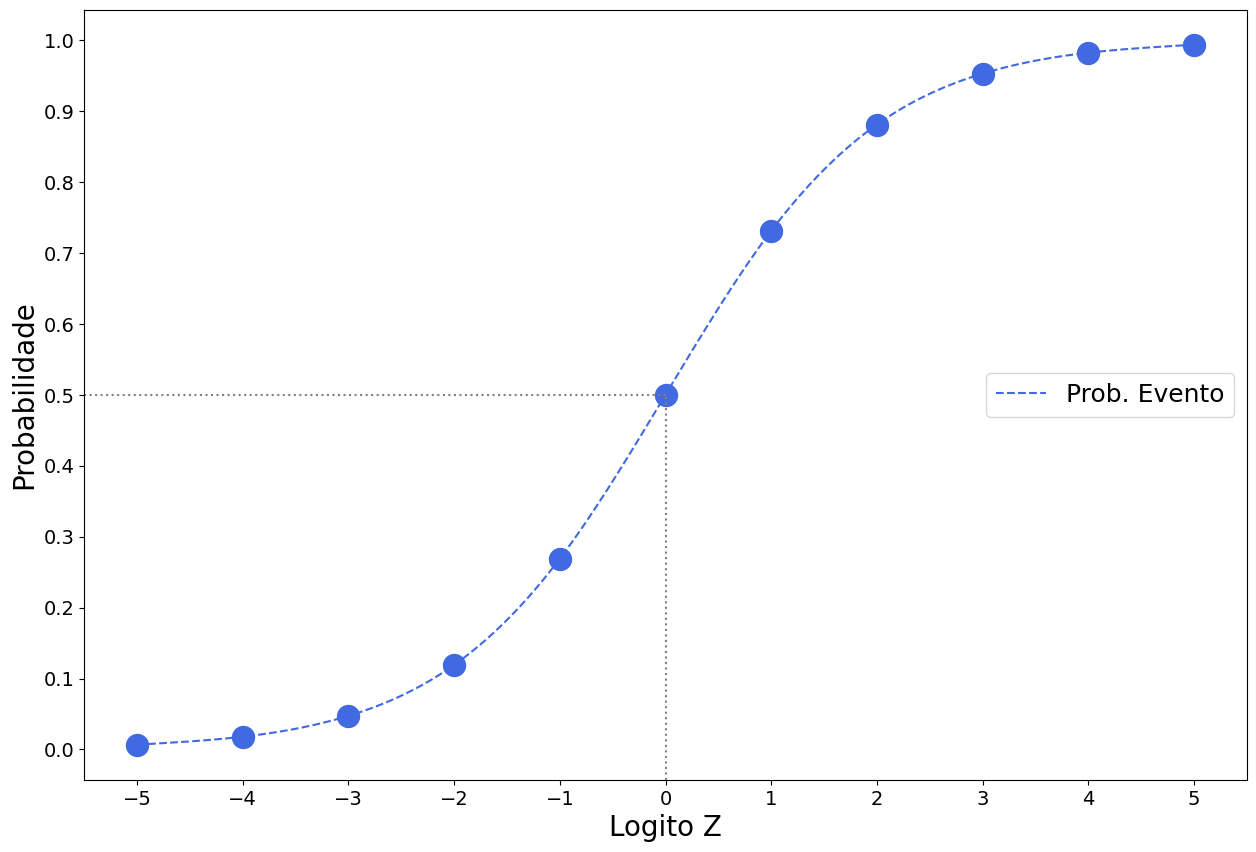

In [2]:
#############################################################################
#                      REGRESSÃO LOGÍSTICA BINÁRIA                          #                  
#               EXEMPLO 1 - CARREGAMENTO DA BASE DE DADOS                   #
#############################################################################

# Estabelecendo uma função para a probabilidade de ocorrência de um evento

from math import exp

# Estabelecendo uma função para a probabilidade de ocorrência de um evento
def prob(z):
    return 1 / (1 + exp(-z))

# In[SIGMOIDE]: Plotando a curva sigmoide teórica de ocorrência de um evento
#para um range do logito z entre -5 e +5

logitos = []
probs = []

for i in np.arange(-5, 6):
    logitos.append(i)
    probs.append(prob(i))
    
df = pd.DataFrame({'logito': logitos, 'probs': probs})

# Interpolação spline (smooth probability line)
spline = UnivariateSpline(df['logito'], df['probs'], s=0)

logitos_smooth = np.linspace(df['logito'].min(), df['logito'].max(), 500)
probs_smooth = spline(logitos_smooth)

plt.figure(figsize=(15,10))
plt.plot(logitos_smooth, probs_smooth, color='royalblue',
         linestyle='--', label='Prob. Evento')
plt.scatter(df['logito'], df['probs'], color='royalblue', marker='o', s=250)
plt.axhline(y = df.probs.mean(), color = 'grey', linestyle = ':', xmax = .5)
plt.axvline(x = 0, color = 'grey', linestyle=':', ymax = 0.5)
plt.xlabel("Logito Z", fontsize=20)
plt.ylabel("Probabilidade", fontsize=20)
plt.xticks(np.arange(-5, 6), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=14)
plt.legend(fontsize=18, loc='center right')
plt.show()

In [4]:
df_atrasado = pd.read_csv('data/atrasado.csv',delimiter=',')
df_atrasado

,estudante,atrasado,dist,sem
0,Gabriela,0,12.5,7
1,Patricia,0,13.3,10
2,Gustavo,0,13.4,8
3,Leticia,0,23.5,7
4,Luiz Ovidio,0,9.5,8
...,...,...,...,...
95,Sheila,1,24.0,10
96,Pedro,1,10.0,10
97,Horacio,1,9.4,10
98,Leandro,1,14.2,10


In [5]:
# Características das variáveis do dataset
df_atrasado.info()

# Estatísticas univariadas
df_atrasado.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   estudante  100 non-null    object 
 1   atrasado   100 non-null    int64  
 2   dist       100 non-null    float64
 3   sem        100 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 3.3+ KB


,atrasado,dist,sem
count,100.000000,100.000000,100.000000
mean,0.590000,14.073000,10.210000
std,0.494311,4.330112,1.578229
min,0.000000,1.000000,5.000000
25%,0.000000,12.000000,10.000000
50%,1.000000,13.350000,10.000000
75%,1.000000,16.125000,10.000000
max,1.000000,29.000000,18.000000


In [6]:
# Tabela de frequências absolutas da variável 'atrasado'

df_atrasado['atrasado'].value_counts().sort_index()

atrasado
0    41
1    59
Name: count, dtype: int64

In [7]:
# Estimação de um modelo logístico binário pela função 'smf.glm'
# ('statsmodels.formula.api')

modelo_atrasos = smf.glm(formula='atrasado ~ dist + sem', data=df_atrasado,
                         family=sm.families.Binomial()).fit()

# Parâmetros do 'modelo_atrasos'
modelo_atrasos.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               atrasado   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50.466
Date:                Tue, 20 Aug 2024   Deviance:                       100.93
Time:                        20:56:31   Pearson chi2:                     86.7
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2913
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -26.1665      8.442     -3.100      0.002     -42.712      -9.621
dist           0.1904      0.076      2.493      0.013       0.041       0.340
sem            2.3629      0.795      2.972      0.003       0.804       3.921
==============================================================================
"""

In [8]:
# Outputs do modelo pela função 'summary_col'

summary_col([modelo_atrasos],
            model_names=["MODELO"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.3f}".format(x.llf)
        })

,MODELO
Intercept,-26.1665***
,(8.4420)
dist,0.1904**
,(0.0764)
sem,2.3629***
,(0.7951)
N,100
Log-lik,-50.466


In [9]:
# Fazendo predições para o 'modelo_atrasos'.
# Exemplo: qual a probabilidade média de se chegar atrasado quando o
# trajeto tem 7 km e passa-se por 10 semáforos no percurso?

modelo_atrasos.predict(pd.DataFrame({'dist':[7], 'sem':[10]}))

0    0.230566
dtype: float64

In [10]:
# Construção de uma matriz de confusão

# Adicionando os valores previstos de probabilidade na base de dados
df_atrasado['phat'] = modelo_atrasos.predict()

# Visualização da base de dados com a variável 'phat'
df_atrasado

,estudante,atrasado,dist,sem,phat
0,Gabriela,0,12.5,7,0.000712
1,Patricia,0,13.3,10,0.498561
2,Gustavo,0,13.4,8,0.008903
3,Leticia,0,23.5,7,0.005751
4,Luiz Ovidio,0,9.5,8,0.004257
...,...,...,...,...,...
95,Sheila,1,24.0,10,0.884040
96,Pedro,1,10.0,10,0.346606
97,Horacio,1,9.4,10,0.321210
98,Leandro,1,14.2,10,0.541301


<function matplotlib.pyplot.show(close=None, block=None)>

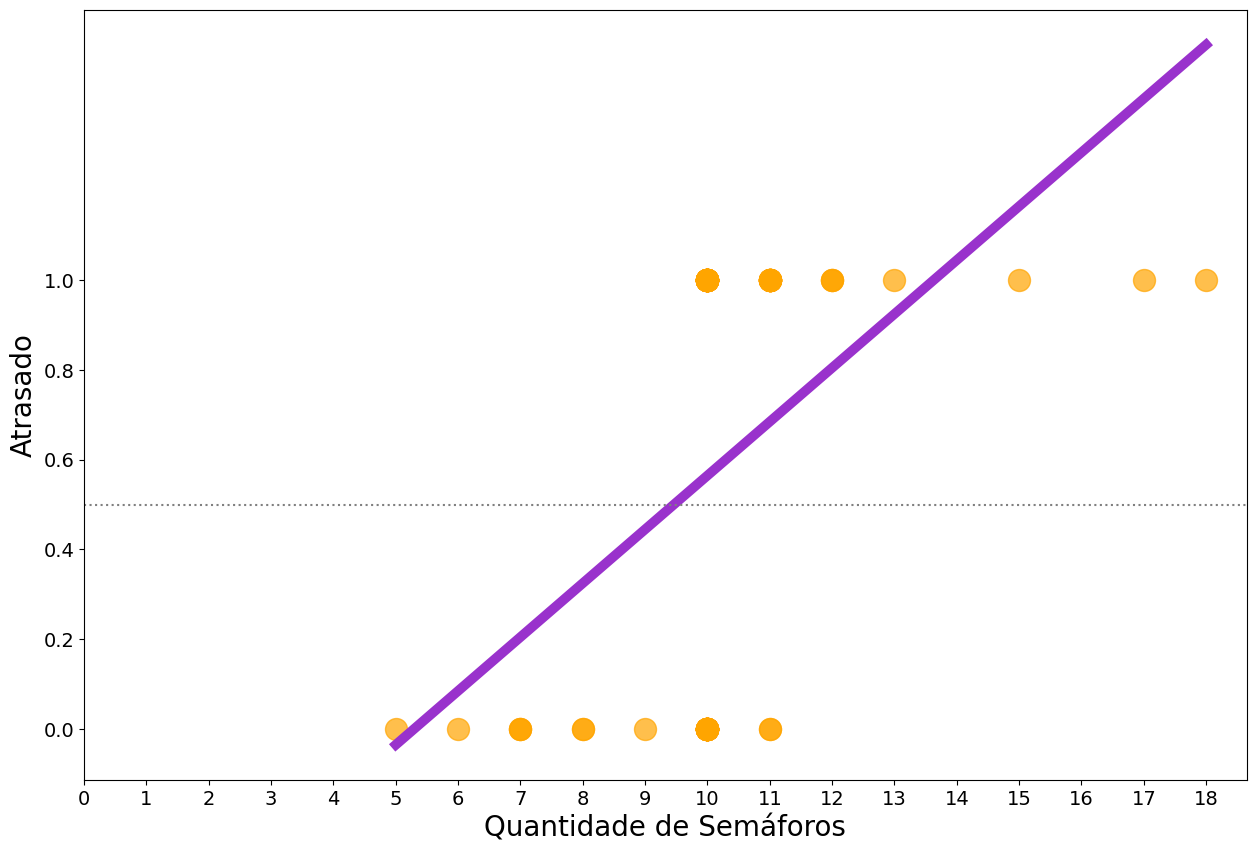

In [11]:
# Gráficos com ajustes entre a variável dependente e a variável 'sem'
    
# Ajuste linear entre a variável dependente e a variável 'sem' (Gráfico errado:
#apenas para fins didáticos)

plt.figure(figsize=(15,10))
sns.regplot(x=df_atrasado['sem'], y=df_atrasado['atrasado'],
            ci=None, marker='o',
            scatter_kws={'color':'orange', 's':250, 'alpha':0.7},
            line_kws={'color':'darkorchid', 'linewidth':7})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Quantidade de Semáforos', fontsize=20)
plt.ylabel('Atrasado', fontsize=20)
plt.xticks(np.arange(0, df_atrasado['sem'].max() + 0.01),
           fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

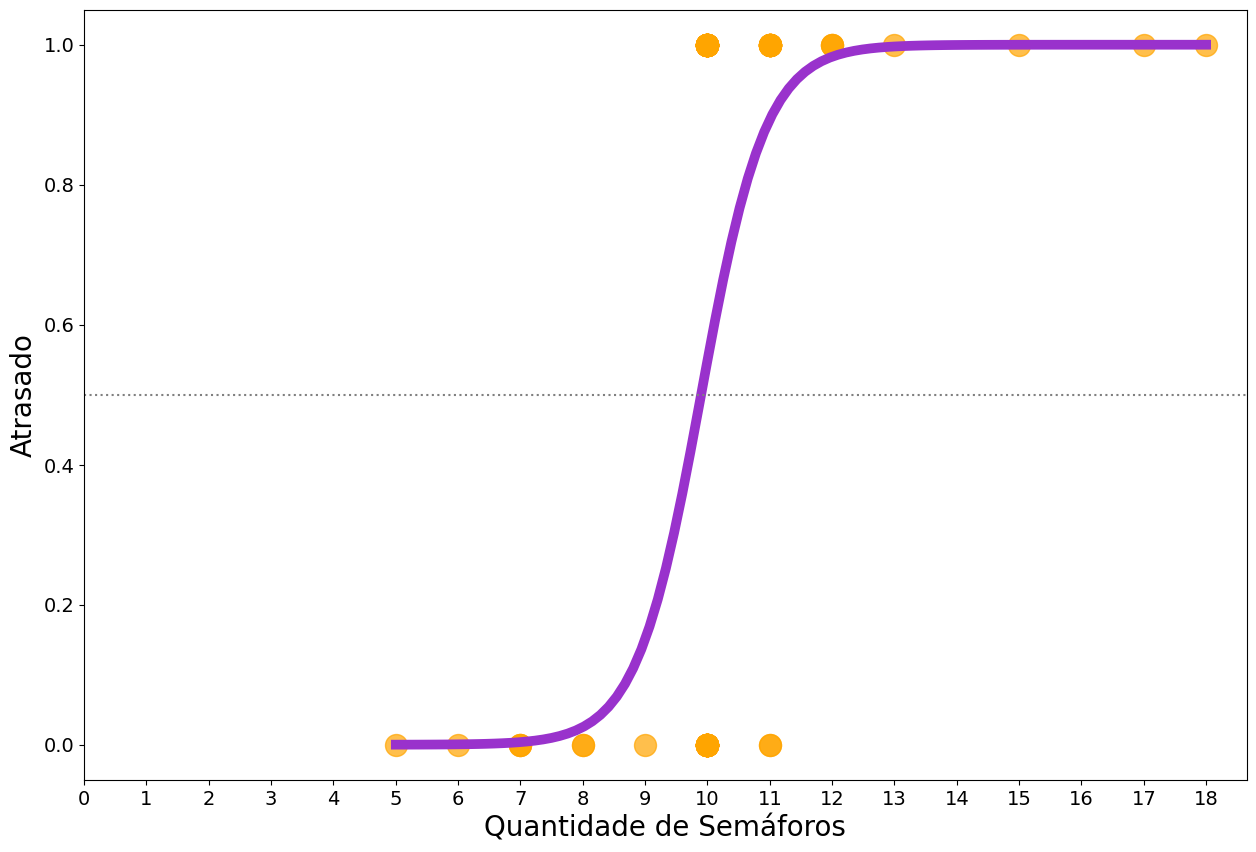

In [12]:
# Ajuste logístico determinístico entre a variável dependente e a
# variável 'sem'

# Sigmoide

plt.figure(figsize=(15,10))
sns.regplot(x=df_atrasado['sem'], y=df_atrasado['atrasado'],
            ci=None, marker='o', logistic=True,
            scatter_kws={'color':'orange', 's':250, 'alpha':0.7},
            line_kws={'color':'darkorchid', 'linewidth':7})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Quantidade de Semáforos', fontsize=20)
plt.ylabel('Atrasado', fontsize=20)
plt.xticks(np.arange(0, df_atrasado['sem'].max() + 0.01),
           fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

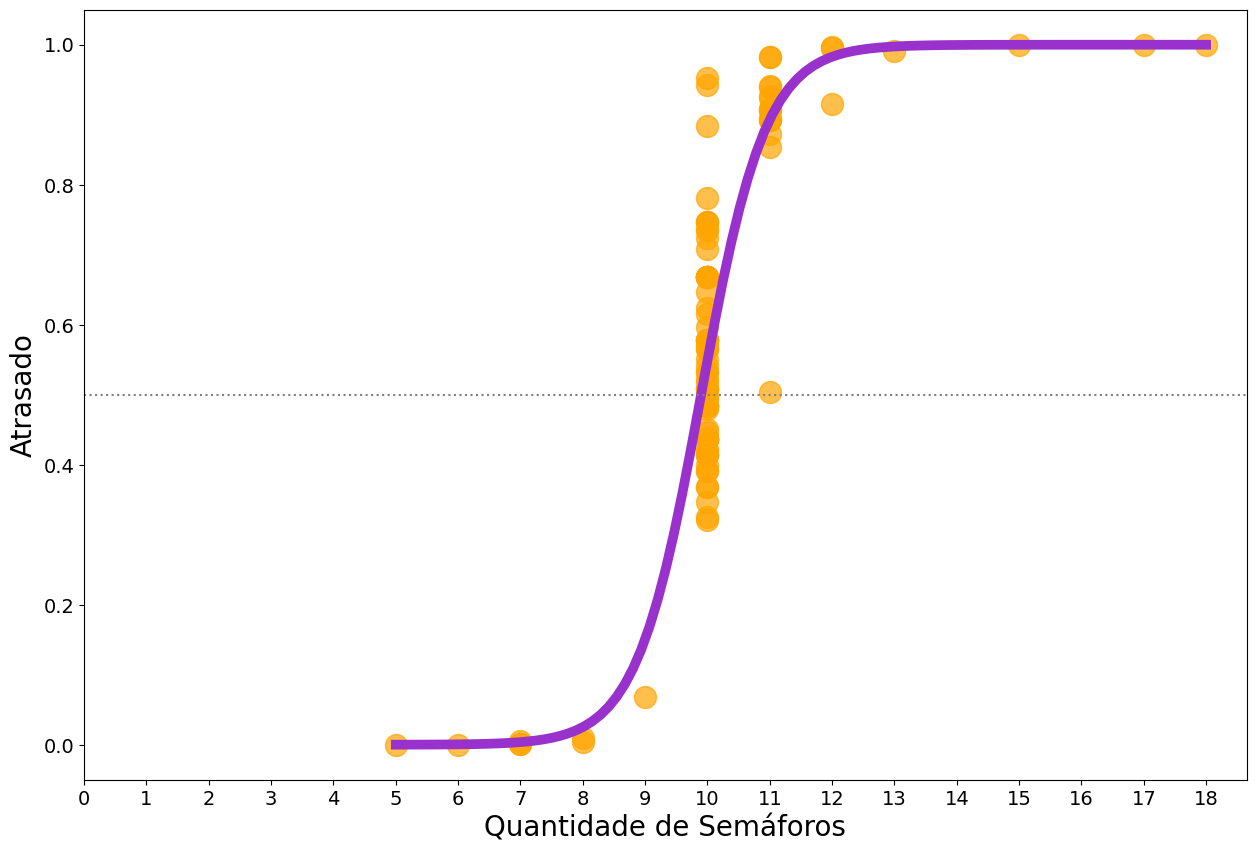

In [13]:
# Ajuste logístico probabilístico entre a variável dependente e a
# variável 'sem'

# Sigmoide

plt.figure(figsize=(15,10))
sns.regplot(x=df_atrasado['sem'], y=df_atrasado['phat'],
            ci=None, marker='o', logistic=True,
            scatter_kws={'color':'orange', 's':250, 'alpha':0.7},
            line_kws={'color':'darkorchid', 'linewidth':7})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Quantidade de Semáforos', fontsize=20)
plt.ylabel('Atrasado', fontsize=20)
plt.xticks(np.arange(0, df_atrasado['sem'].max() + 0.01),
           fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show

In [14]:
# Construção de função para a definição da matriz de confusão

from sklearn.metrics import confusion_matrix, accuracy_score,\
    ConfusionMatrixDisplay, recall_score

def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    # Visualização dos principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

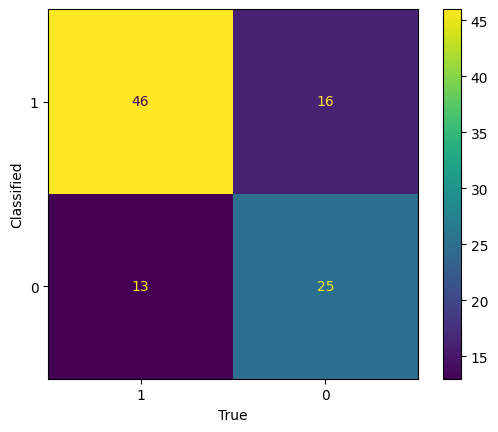

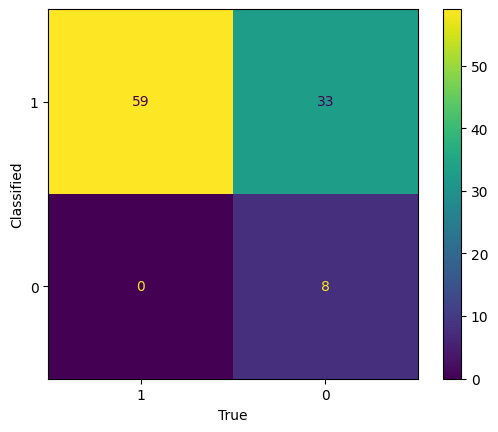

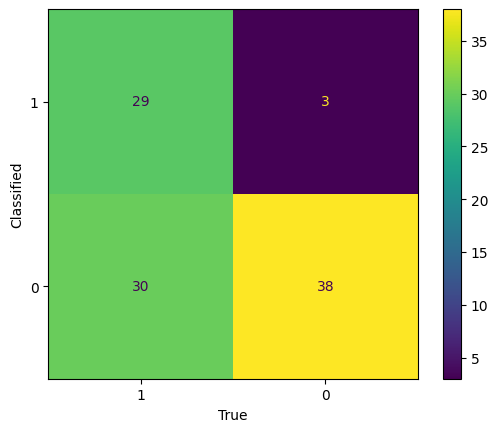

,Sensitividade,Especificidade,Acurácia
0,0.491525,0.926829,0.67


In [15]:
# Matrizes de confusão propriamente ditas

# Matriz de confusão para cutoff = 0.5
matriz_confusao(observado=df_atrasado['atrasado'],
                predicts=df_atrasado['phat'], 
                cutoff=0.5)

# Matriz de confusão para cutoff = 0.3
matriz_confusao(observado=df_atrasado['atrasado'],
                predicts=df_atrasado['phat'], 
                cutoff=0.3)

# Matriz de confusão para cutoff = 0.7
matriz_confusao(observado=df_atrasado['atrasado'],
                predicts=df_atrasado['phat'], 
                cutoff=0.7)

In [16]:
# Igualando critérios de especificidade e de sensitividade

# Tentaremos estabelecer um critério que iguale a probabilidade de
# acerto daqueles que chegarão atrasados (sensitividade) e a probabilidade de
# acerto daqueles que não chegarão atrasados (especificidade).

# ATENÇÃO: o que será feito a seguir possui fins didáticos, apenas. DE NENHUMA
# FORMA, o procedimento garante a maximização da acurácia do modelo!

# Criação da função 'espec_sens' para a construção de um dataset com diferentes
# valores de cutoff, sensitividade e especificidade:

def espec_sens(observado,predicts):
    
    # Adicionar objeto com os valores dos predicts
    values = predicts.values
    
    # Range dos cutoffs a serem analisados em steps de 0.01
    cutoffs = np.arange(0,1.01,0.01)
    
    # Listas que receberão os resultados de especificidade e sensitividade
    lista_sensitividade = []
    lista_especificidade = []
    
    for cutoff in cutoffs:
        
        predicao_binaria = []
        
        # Definindo resultado binário de acordo com o predict
        for item in values:
            if item >= cutoff:
                predicao_binaria.append(1)
            else:
                predicao_binaria.append(0)
                
        # Cálculo da sensitividade e especificidade no cutoff
        sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
        especificidadee = recall_score(observado, predicao_binaria, pos_label=0)
        
        # Adicionar valores nas listas
        lista_sensitividade.append(sensitividade)
        lista_especificidade.append(especificidadee)
        
    # Criar dataframe com os resultados nos seus respectivos cutoffs
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitividade':lista_sensitividade,'especificidade':lista_especificidade})
    return resultado

In [17]:
# Até o momento, foram extraídos 3 vetores: 'sensitividade',
# 'especificidade' e 'cutoffs'. Assim, criamos um dataframe que contém
# os vetores mencionados (dataframe 'dados_plotagem')

dados_plotagem = espec_sens(observado = df_atrasado['atrasado'],
                            predicts = df_atrasado['phat'])
dados_plotagem

,cutoffs,sensitividade,especificidade
0,0.00,1.000000,0.000000
1,0.01,1.000000,0.170732
2,0.02,1.000000,0.170732
3,0.03,1.000000,0.170732
4,0.04,1.000000,0.170732
...,...,...,...
96,0.96,0.135593,1.000000
97,0.97,0.135593,1.000000
98,0.98,0.135593,1.000000
99,0.99,0.101695,1.000000


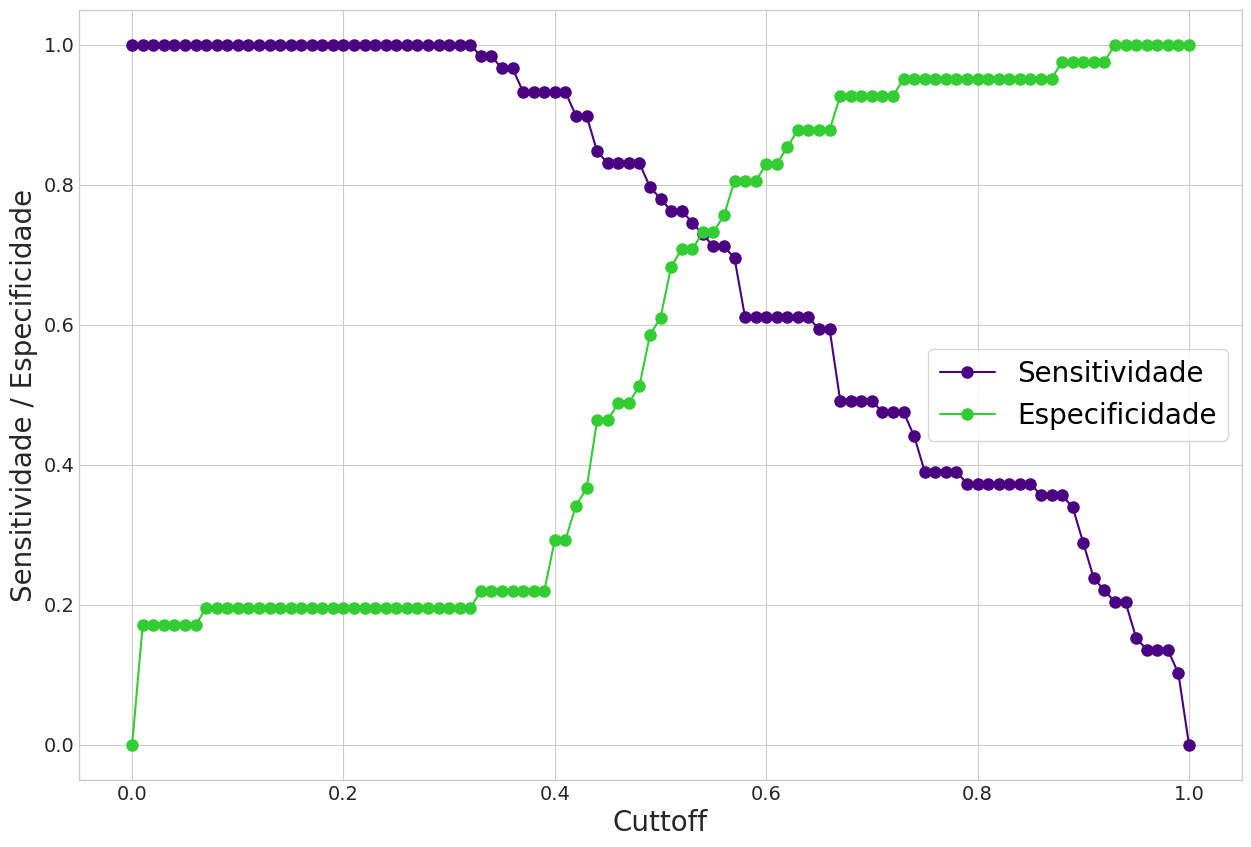

In [18]:
# Plotagem de um gráfico que mostra a variação da especificidade e da
# sensitividade em função do cutoff

plt.figure(figsize=(15,10))
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.sensitividade, marker='o',
         color='indigo', markersize=8)
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.especificidade, marker='o',
         color='limegreen', markersize=8)
plt.xlabel('Cuttoff', fontsize=20)
plt.ylabel('Sensitividade / Especificidade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.legend(['Sensitividade', 'Especificidade'], fontsize=20)
plt.show()

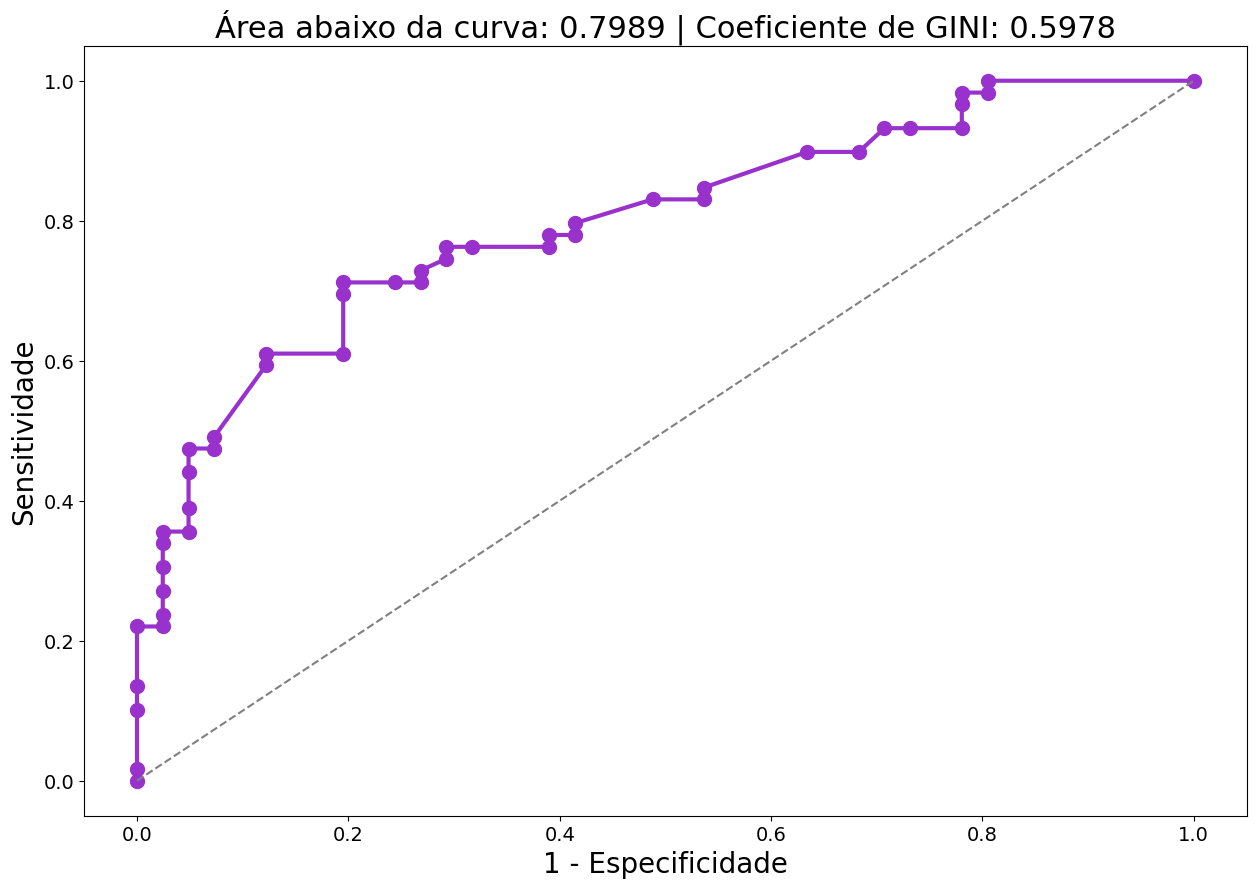

In [19]:
# Construção da curva ROC

from sklearn.metrics import roc_curve, auc

# Função 'roc_curve' do pacote 'metrics' do sklearn

fpr, tpr, thresholds =roc_curve(df_atrasado['atrasado'], df_atrasado['phat'])
roc_auc = auc(fpr, tpr)

# Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)

# Plotando a curva ROC
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Área abaixo da curva: %g' % round(roc_auc, 4) +
          ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=20)
plt.ylabel('Sensitividade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()